#### Pose 1 / 18 trial 1 / 20 ####
#### Pose 1 / 18 trial 2 / 20 ####
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0
#### Pose 2 / 18 trial 1 / 20 ####
#### Pose 2 / 18 trial 2 / 20 ####
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0
#### Pose 3 / 18 trial 1 / 20 ####
#### Pose 3 / 18 trial 2 / 20 ####
[0, 0, 0, 0, 0, 

KeyboardInterrupt: 

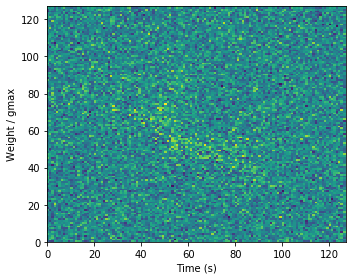

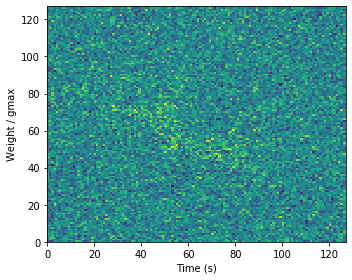

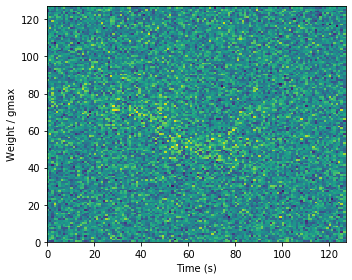

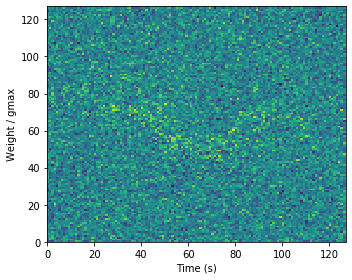

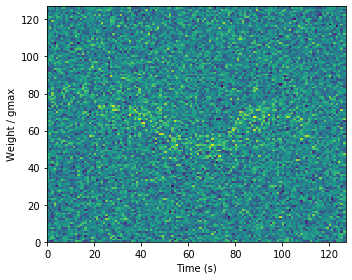

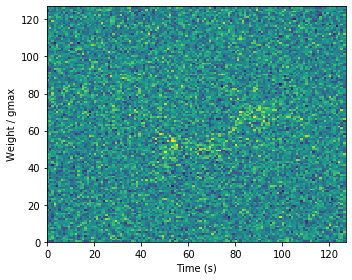

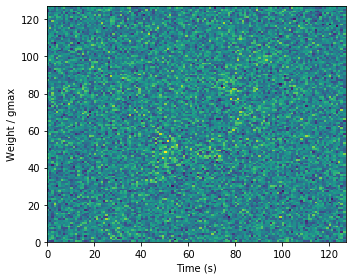

<Figure size 360x288 with 0 Axes>

In [2]:
from brian2 import *
import numpy as np
import pickle
import time, os, json
from collections import OrderedDict
from IPython.lib import kernel

import matplotlib.pyplot as plt

def main():
    
    start_scope()

    # Data directory
    data_dir_name = 'collect_orientation_tap'
    home_dir = os.path.join(os.environ['DATAPATH'], 'TacTip_NM', 'edgeTap_Dobot')
    data_dir = os.path.join(home_dir, data_dir_name)
    fig_save_dir = os.path.join(os.environ['PAPERPATH'],'2020_ICRA_TacTip-N_EdgeOrientation','figures', data_dir_name)
    if not os.path.exists(fig_save_dir):
      os.mkdir(fig_save_dir)

  # Load metadata
    with open(data_dir + "/meta.json", "r") as read_file:
      meta = json.load(read_file)

    # Simulation parameters
    runtime = 1000*ms
    WINDOW_WIDTH = 128
    WINDOW_HEIGHT = 128
    n_inputs = WINDOW_WIDTH*WINDOW_HEIGHT
#     weight = 10*mV
    taum = 10*ms
    taupre = 20*ms
    taupost = taupre
    Ee = 0*mV
    vt = -50*mV
    vr = -70*mV
    El = -70*mV
    taue = 5*ms
    F = 15*Hz
    gmax = 1
    dApre = .1
    dApost = -dApre * taupre / taupost * 1.05
    dApost *= gmax
    dApre *= gmax

    # Layers
    input = SpikeGeneratorGroup(n_inputs, []*n_inputs, []*n_inputs*ms)   
    eqs = '''
    dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
    dge/dt = -ge / taue : 1
    '''
#     eqs = '''dvm/dt = ((El - vm) + I)/tau : volt
#          I : volt'''   
    hidden = NeuronGroup(n_inputs, eqs, threshold='v > vt', reset='v = vr', method='exact')
    hidden.v=-70*volt    
    
    # Connections
    synapses_stdp = Synapses(input, hidden,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
    synapses_stdp.connect(j='k for k in range(i-3, i+4)', skip_if_invalid=True)
    synapses_stdp.w = 'rand() * gmax'
    
    # Monitors
    input_mon = SpikeMonitor(input)
    weights_mon = StateMonitor(synapses_stdp,'w', record=range(0,1000,10))
    hidden_mon = SpikeMonitor(hidden)

    # Store network state
    net = Network(input, hidden, synapses_stdp,input_mon, weights_mon, hidden_mon)
    net.store('initialized')

    ###########################################################################################################################################################################
    # training loop 
    for pose_idx in range(meta['num_poses']):
    #   for pose_idx in range(1):
        net.restore('initialized')
        
#         for trial_idx in range(meta['num_trials']):
        for trial_idx in range(2):
            print('#### Pose ' + str(pose_idx+1) + ' / ' + str(meta['num_poses']) + ' trial ' + str(trial_idx+1) + ' / ' + str(meta['num_trials']) + ' ####')
           
            # Load data
            filename = os.path.join(data_dir, 'data_pose_' + str(pose_idx) + '_trial_' + str(trial_idx)+'.pickle')
            infile = open(filename,'rb')
            data = pickle.load(infile)       
            infile.close()
            data = remove_duplicates(data)

            # Generate spikes for network
            spikes_i = []
            spikes_t = []
            for i in range(WINDOW_WIDTH):
                for j in range(WINDOW_HEIGHT):
                    if data[i][j] != []:
                        for d in data[i][j]:
                            spikes_i.append(i*WINDOW_WIDTH+j)
                            spikes_t.append(d+1000*trial_idx)
            input.set_spikes(spikes_i,spikes_t*ms)

            # Make connectivity figures
            if pose_idx == 0 and trial_idx ==0:
                fig_connectivity(synapses_stdp)
                
            # Run network
            net.run(runtime)

            # Figures
#             fig_spikes(input_mon,hidden_mon,pose_idx,trial_idx)
#             fig_heatmap(input_mon,hidden_mon,pose_idx,trial_idx)
#         fig_STDP(S, weights_mon, gmax,pose_idx,trial_idx)
        fig_weights_heatmap(synapses_stdp, weights_mon, gmax,pose_idx,trial_idx)
            
    net.store('after_training')

    #    for test_number in range(5):
    #         restore('after_learning')
    #         S.plastic = False  # switch plasticity off
    #         G.test_input = test_inputs[test_number]
    #         # monitor the activity now
    #         spike_mon = SpikeMonitor(G)
    #         run(...)
    
def remove_duplicates(data):
    for i in range(len(data)):
        for j in range(len(data[i])): 
            data[i][j] = list(OrderedDict.fromkeys(data[i][j]))
    return data

def fig_connectivity(S):
#     Ns = len(S.source)
#     Nt = len(S.target)
    Ns = 10
    Nt = 10
    figure(figsize=(5, 4))
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i[:62], S.j[:62]):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt)-1)
    title('Network connectivity')
    plt.savefig('figures/stdp_test/connectivity')

def fig_spikes(spikes_input, spikes_hidden, pose_idx, trial_idx):
    fig_dir = os.path.join('figures', 'stdp_test', 'spikes')
    if not os.path.exists(fig_dir):
        os.mkdir(fig_dir)
    figure(figsize=(12,4))
    subplot(121)
    plot(spikes_input.t/ms, spikes_input.i, '.k')
    xlabel('Time (ms)')
    ylabel('Neuron index')
    xlim([0, 1000])
    title('Input spikes')
    subplot(122)
    plot(spikes_hidden.t/ms, spikes_hidden.i, '.k')
    xlabel('Time(ms)')
    ylabel('Neuron index')
    xlim([0, 1000])
    title('Layer 1 spikes')
    #   plt.show()
    plt.savefig(fig_dir + '/spikes_pose_'+str(pose_idx)+'_trial_'+str(trial_idx))
    plt.close()
  
def fig_heatmap(spikes_input, spikes_hidden, pose_idx, trial_idx):
    fig_dir = os.path.join('figures', 'stdp_test', 'heatmap')
    if not os.path.exists(fig_dir):
        os.mkdir(fig_dir)
    figure(figsize=(12,4))
    subplot(121)
    x = []
    y = []
    for spike in spikes_input.i:  
      x.append(spike//128)
      y.append(spike%128)
    plt.hist2d(x, y, 64, range=np.array([(0, 128), (0, 128)]))
    xlabel('x pixel')
    ylabel('y pixel')
    xlim([0, 128])
    ylim([0, 128])
    title('Input spikes heatmap')
    subplot(122)
    x = []
    y = []
    for spike in spikes_hidden.i:  
      x.append(spike//128)
      y.append(spike%128)
    plt.hist2d(x, y, 64, range=np.array([(0, 128), (0, 128)]))
    xlim([0, 128])
    ylim([0, 128])
    xlabel('x pixel')
    ylabel('y pixel')
    title('Layer 1 spikes heatmap')
    #   plt.show()
    plt.savefig(fig_dir + '/heatmap_pose_'+str(pose_idx)+'_trial_'+str(trial_idx))
    plt.close()

def fig_STDP(synapses, weights_mon, gmax, pose_idx, trial_idx):
    fig_dir = os.path.join('figures', 'stdp_test', 'STDP')
    if not os.path.exists(fig_dir):
        os.mkdir(fig_dir)
#     subplot(311)
#     plot(synapses.w / gmax, '.k')
#     ylabel('Weight / gmax')
#     xlabel('Synapse index')
    subplot(312)
    hist(synapses.w / gmax, 20)
    xlabel('Weight / gmax')
    subplot(313)
    plot(weights_mon.t/second, weights_mon.w.T/gmax)
    xlabel('Time (s)')
    ylabel('Weight / gmax')
    tight_layout()
    plt.savefig(fig_dir + '/STDP_pose_'+str(pose_idx)+'_trial_'+str(trial_idx))
#     show()

def fig_weights_heatmap(synapses, weights_mon, gmax, pose_idx, trial_idx):
    fig_dir = os.path.join('figures', 'stdp_test', 'weights_heatmap')
    if not os.path.exists(fig_dir):
        os.mkdir(fig_dir)
    figure(figsize=(5, 4))
#     subplot(311)
#     plot(synapses.w / gmax, '.k')
#     ylabel('Weight / gmax')
#     xlabel('Synapse index')
    
    dx, dy = 1, 1
    y, x = np.mgrid[slice(0, 127 + dy, dy),
                slice(0, 127 + dx, dx)]
    z = [[0]*128 for x in range(128)]

#     z = np.sin(x)**10 + np.cos(10 + y*x) * np.cos(x)
    print(z[0])
    print(z[0][0])
              
    for i in range(len(synapses.w)):
        synapse = synapses.j[i]
        weight = synapses.w[i]
        row = synapse//128
        column = synapse%128
        z[row][column] =z[row][column] + weight

    plt.pcolormesh(x,y,z)
    xlabel('Time (s)')
    ylabel('Weight / gmax')
    tight_layout()
    plt.savefig(fig_dir + '/STDP_pose_'+str(pose_idx)+'_trial_'+str(trial_idx))
    
if __name__ == '__main__':
    main()
    